### Module import

In [4]:
pip install opencv-python

     ---------------------------------------- 35.6/35.6 MB 4.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import PIL
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms
from torchvision.utils import make_grid, save_image
!pip install pytorch-gradcam

from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp

device = 'cuda' if torch.cuda.is_available() else 'cpu'

ModuleNotFoundError: No module named 'torch.nn'

### Load image

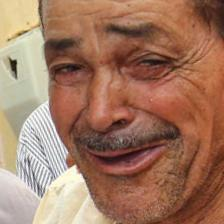

In [48]:
img_dir = 'images'
# img_name = 'collies.JPG'
# img_name = 'multiple_dogs.jpg'
# img_name = 'snake.JPEG'
img_name = '3605.jpg'
img_path = os.path.join(img_dir, img_name)

pil_img = PIL.Image.open(img_path)
pil_img

### preprocess image

In [49]:
torch_img = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])(pil_img).to(device)
normed_torch_img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(torch_img)[None]

### Load torchvision models and make configs

In [50]:
alexnet = models.alexnet(pretrained=True)
vgg = models.vgg16(pretrained=True)
#resnet = models.resnet101(pretrained=True)
#densenet = models.densenet161(pretrained=True)
#squeezenet = models.squeezenet1_1(pretrained=True)

In [51]:
configs = [
    dict(model_type='alexnet', arch=alexnet, layer_name='features_11'),
    dict(model_type='vgg', arch=vgg, layer_name='features_29')
    
]

In [52]:
for config in configs:
    config['arch'].to(device).eval()

cams = [
    [cls.from_config(**config) for cls in (GradCAM, GradCAMpp)]
    for config in configs
]

### Feedforward image, calculate GradCAM/GradCAM++, and gather results

In [53]:
images = []
for gradcam, gradcam_pp in cams:
    mask, _ = gradcam(normed_torch_img)
    heatmap, result = visualize_cam(mask, torch_img)

    mask_pp, _ = gradcam_pp(normed_torch_img)
    heatmap_pp, result_pp = visualize_cam(mask_pp, torch_img)
    
    images.extend([torch_img.cpu(), heatmap, heatmap_pp, result, result_pp])
    
grid_image = make_grid(images, nrow=5)

### Show results 

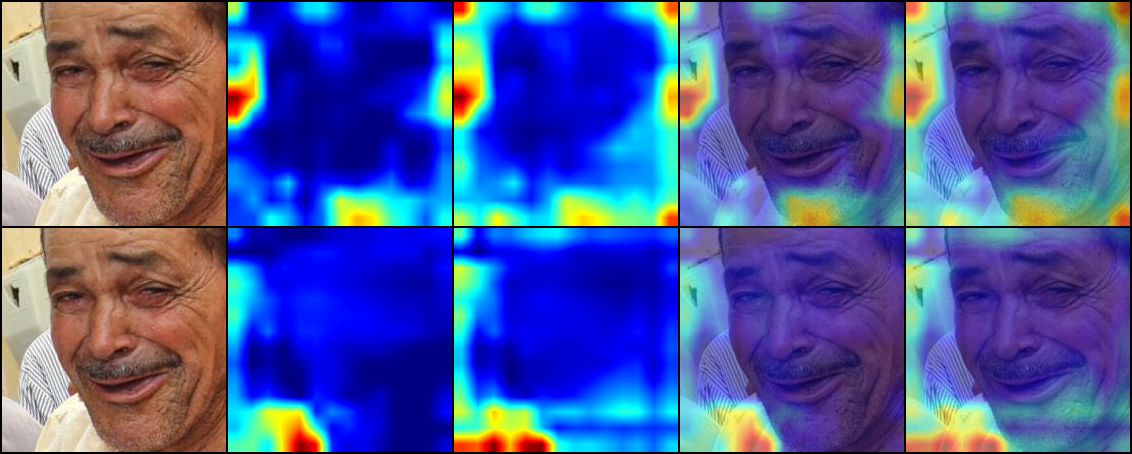

In [54]:
transforms.ToPILImage()(grid_image)